In [2]:
import pandas as pd
import numpy as np

from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
DATA_PATH = Path("C:/Users/prate/Downloads/fraudTest.csv/fraudTest.csv")
df = pd.read_csv(DATA_PATH)

In [4]:
df = df.drop(columns=["Unnamed: 0"])
df.shape

(555719, 22)

In [5]:
df = df[
    [
        "cc_num",
        "category",
        "amt",
        "unix_time",
        "lat",
        "long",
        "merch_lat",
        "merch_long",
        "is_fraud"
    ]
]

In [6]:
df = df.sort_values(by=["cc_num", "unix_time"])
df.reset_index(drop=True, inplace=True)

In [7]:
df["txn_count_cust"] = df.groupby("cc_num").cumcount()

In [8]:
df["cust_avg_amt"] = (
    df.groupby("cc_num")["amt"].transform("mean")
)

In [9]:
df["amt_deviation"] = (df["amt"] - df["cust_avg_amt"]).abs()

In [10]:
df["cust_category_count"] = (
    df.groupby(["cc_num", "category"]).cumcount()
)

In [11]:
from math import radians, sin, cos, asin, sqrt

def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    c = 2*asin(sqrt(a))
    return 6371 * c

df["distance_from_home"] = df.apply(
    lambda x: haversine(
        x["lat"], x["long"],
        x["merch_lat"], x["merch_long"]
    ),
    axis=1
)

In [12]:
df = df.drop(
    columns=[
        "cust_avg_amt",
        "lat", "long", "merch_lat", "merch_long"
    ]
)

In [13]:
df = pd.get_dummies(df, columns=["category"], drop_first=True)

In [14]:
y = df["is_fraud"]
X = df.drop(columns=["is_fraud", "cc_num"])

In [15]:
# Train on NORMAL only
X_train = X[y == 0].sample(frac=0.8, random_state=42)

# Validate on mixed data
X_val = X.drop(X_train.index)
y_val = y.loc[X_val.index].values

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

## Isolation forest

In [17]:
iso = IsolationForest(
    n_estimators=300,
    contamination=0.01,
    random_state=42,
    n_jobs=-1
)

iso.fit(X_train_scaled)

IsolationForest(contamination=0.01, n_estimators=300, n_jobs=-1,
                random_state=42)

In [18]:
iso_scores = -iso.decision_function(X_val_scaled)

threshold = np.percentile(iso_scores, 98)
y_pred_iso = (iso_scores >= threshold).astype(int)

(
    precision_score(y_val, y_pred_iso),
    recall_score(y_val, y_pred_iso),
    f1_score(y_val, y_pred_iso),
    roc_auc_score(y_val, iso_scores)
)

(0.43844109831709477,
 0.46153846153846156,
 0.44969339086986143,
 0.8855216300657297)

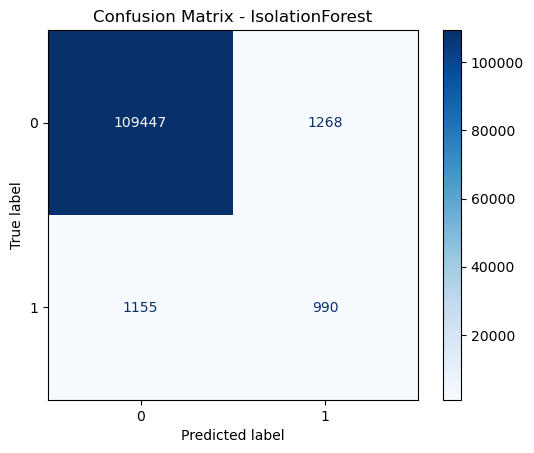

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm_oc = confusion_matrix(y_val, y_pred_iso)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_oc)
disp.plot(cmap="Blues")

plt.title("Confusion Matrix - IsolationForest")
plt.show()

## Autoencoder

In [20]:
input_dim = X_train_scaled.shape[1]

inp = Input(shape=(input_dim,))
enc = Dense(32, activation="relu")(inp)
enc = Dense(16, activation="relu")(enc)
dec = Dense(32, activation="relu")(enc)
out = Dense(input_dim)(dec)

ae = Model(inp, out)
ae.compile(optimizer="adam", loss="mse")

In [21]:
ae.fit(
    X_train_scaled,
    X_train_scaled,
    epochs=40,
    batch_size=256,
    validation_split=0.1,
    callbacks=[EarlyStopping(patience=5)],
    verbose=1
)

Epoch 1/40
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.2651 - val_loss: 0.0098
Epoch 2/40
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0097 - val_loss: 0.0056
Epoch 3/40
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0052 - val_loss: 0.0033
Epoch 4/40
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0032 - val_loss: 0.0020
Epoch 5/40
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 6/40
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 7/40
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 8/40
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0011 - val_loss: 0.0027
Epoch 9/40
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0012 - val_loss: 8.3881e-04
Epoch 10/40
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 8.3025e-04 - val_loss: 6.7955e-04
Epoch 11/40
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 8.1430e-04 - val_loss: 5.8816e-04
Epoch 12/4

In [22]:
X_val_pred = ae.predict(X_val_scaled)
recon_error = np.mean((X_val_scaled - X_val_pred)**2, axis=1)

threshold = np.percentile(recon_error, 98)
y_pred_ae = (recon_error >= threshold).astype(int)

(
    precision_score(y_val, y_pred_ae),
    recall_score(y_val, y_pred_ae),
    f1_score(y_val, y_pred_ae),
    roc_auc_score(y_val, recon_error)
)

3527/3527 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


(0.24136403897254208,
 0.2540792540792541,
 0.2475584828526005,
 0.8599045092257394)

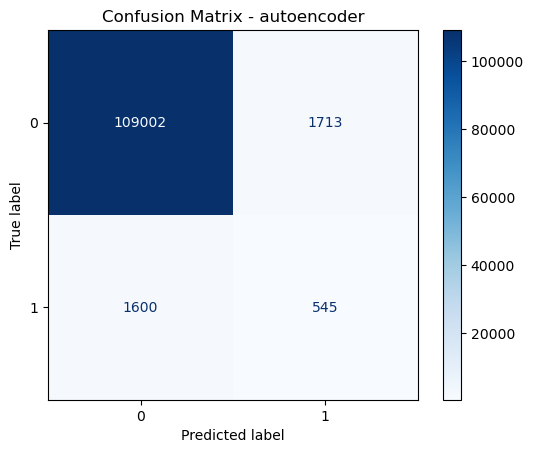

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm_oc = confusion_matrix(y_val, y_pred_ae)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_oc)
disp.plot(cmap="Blues")

plt.title("Confusion Matrix - autoencoder")
plt.show()

In [24]:
y_pred_or = ((y_pred_iso == 1) | (y_pred_ae == 1)).astype(int)

(
    precision_score(y_val, y_pred_or),
    recall_score(y_val, y_pred_or),
    f1_score(y_val, y_pred_or),
    roc_auc_score(y_val, recon_error)
)

(0.33016562584849307,
 0.566899766899767,
 0.4172958133150309,
 0.8599045092257394)

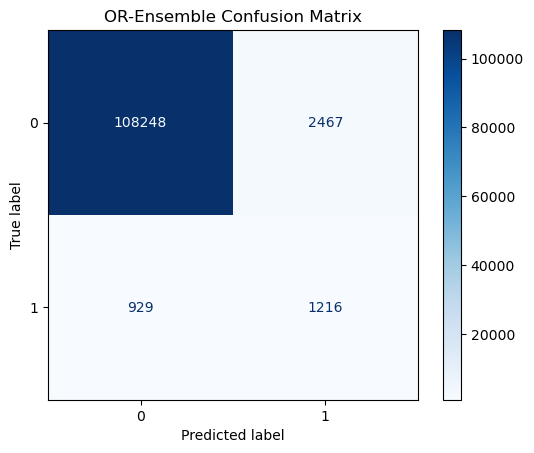

In [25]:
cm = confusion_matrix(y_val, y_pred_or)

disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap="Blues")
plt.title("OR-Ensemble Confusion Matrix")
plt.show()

Point-based anomaly detection failed because fraud was contextual. After introducing behavioral features capturing deviation from customer-specific baselines, recall improved significantly while maintaining low latency

In [26]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

score_scaler = MinMaxScaler()

iso_norm = score_scaler.fit_transform(
    iso_scores.reshape(-1, 1)
).ravel()

ae_norm = score_scaler.fit_transform(
    recon_error.reshape(-1, 1)
).ravel()

In [27]:
def business_cost(y_true, y_pred, fp_cost=10, fn_cost=1):
    fp = np.sum((y_pred == 1) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    return fp_cost * fp + fn_cost * fn

In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score

weight_grid = np.round(np.arange(0.0, 1.01, 0.1), 2)
threshold_percentiles = np.arange(95.0, 99.91, 0.01)

best_result = {
    "cost": np.inf,
    "w_iso": None,
    "w_ae": None,
    "threshold": None,
    "precision": None,
    "recall": None,
    "f1": None
}

for w_iso in weight_grid:
    w_ae = 1.0 - w_iso
    ensemble_score = w_iso * iso_norm + w_ae * ae_norm

    thresholds = np.percentile(ensemble_score, threshold_percentiles)

    for t in thresholds:
        y_pred = (ensemble_score >= t).astype(int)
        cost = business_cost(y_val, y_pred)

        if cost < best_result["cost"]:
            best_result.update({
                "cost": cost,
                "w_iso": w_iso,
                "w_ae": w_ae,
                "threshold": t,
                "precision": precision_score(y_val, y_pred, zero_division=0),
                "recall": recall_score(y_val, y_pred, zero_division=0),
                "f1": f1_score(y_val, y_pred, zero_division=0)
            })

In [29]:
best_result

{'cost': 2153,
 'w_iso': 0.0,
 'w_ae': 1.0,
 'threshold': 0.03226038071593427,
 'precision': 0.9026548672566371,
 'recall': 0.04755244755244755,
 'f1': 0.09034543844109831}

In [30]:
final_score = (
    best_result["w_iso"] * iso_norm +
    best_result["w_ae"] * ae_norm
)

y_pred_cost = (final_score >= best_result["threshold"]).astype(int)

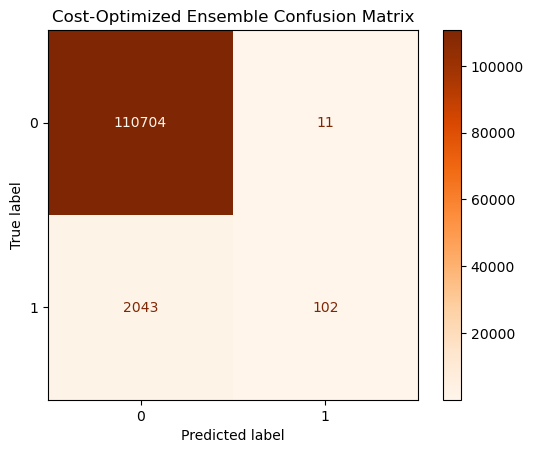

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val, y_pred_cost)

disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap="Oranges")
plt.title("Cost-Optimized Ensemble Confusion Matrix")
plt.show()

In [32]:
fraud_probability = MinMaxScaler().fit_transform(
    final_score.reshape(-1, 1)
).ravel()

In [33]:
def generate_reason(row):
    reasons = []

    if row["amt_deviation"] > row["amt_deviation"].quantile(0.95):
        reasons.append("Transaction amount deviates significantly from customer’s usual spending")

    if row["txn_count_cust"] > row["txn_count_cust"].quantile(0.95):
        reasons.append("High transaction velocity for this customer")

    if row["cust_category_count"] == 0:
        reasons.append("Merchant category not previously seen for this customer")

    if row["distance_from_home"] > row["distance_from_home"].quantile(0.95):
        reasons.append("Transaction location far from customer’s typical location")

    return reasons[:3]  # limit for API

## API Deployment

In [34]:
AVAILABLE_MODELS = {
    "isolation_forest": "Isolation Forest (baseline, fast)",
    "autoencoder": "Autoencoder (default, balanced)",
    "or_ensemble": "Isolation Forest + Autoencoder (high recall)"
}

Default model for production inference: Autoencoder
Alternative high-recall option: OR-Ensemble
Isolation Forest retained as a fast baseline
Cost-optimized ensemble rejected due to unacceptable recall

In [35]:
import os

os.makedirs("artifacts/models", exist_ok=True)
os.makedirs("artifacts/config", exist_ok=True)

In [36]:
import joblib

joblib.dump(iso, "artifacts/models/isolation_forest.pkl")

['artifacts/models/isolation_forest.pkl']

In [37]:
ae.save("artifacts/models/autoencoder.keras")

In [38]:
joblib.dump(scaler, "artifacts/models/scaler.pkl")

['artifacts/models/scaler.pkl']

In [39]:
import json

or_ensemble_config = {
    "type": "or_ensemble",
    "models": ["isolation_forest", "autoencoder"],
    "description": "High recall mode using logical OR"
}

with open("artifacts/config/or_ensemble.json", "w") as f:
    json.dump(or_ensemble_config, f, indent=4)

In [40]:
model_registry = {
    "default_model": "autoencoder",
    "available_models": {
        "isolation_forest": {
            "path": "artifacts/models/isolation_forest.pkl",
            "type": "sklearn",
            "description": "Fast baseline model"
        },
        "autoencoder": {
            "path": "artifacts/models/autoencoder",
            "type": "tensorflow",
            "description": "Balanced default fraud detector"
        },
        "or_ensemble": {
            "path": "artifacts/config/or_ensemble.json",
            "type": "ensemble",
            "description": "High recall fraud detection mode"
        }
    }
}

with open("artifacts/config/model_registry.json", "w") as f:
    json.dump(model_registry, f, indent=4)

In [41]:
!tree artifacts /f

Folder PATH listing for volume Prateeek
Volume serial number is 8E52-0FE4
C:\USERS\PRATE\FRAUD_DETECTION_PROJECT\ARTIFACTS
+---config
¦       model_registry.json
¦       or_ensemble.json
¦       
+---models
        autoencoder.keras
        isolation_forest.pkl
        scaler.pkl
        


In [42]:
import os
print(os.getcwd())

C:\Users\prate\fraud_detection_project


In [43]:
import os

print(os.listdir("artifacts/models"))
print(os.listdir("artifacts/config"))

['autoencoder.keras', 'isolation_forest.pkl', 'scaler.pkl']
['model_registry.json', 'or_ensemble.json']


In [44]:
pip install notebook

Note: you may need to restart the kernel to use updated packages.


In [45]:
import json
import joblib
import tensorflow as tf
from pathlib import Path

BASE_DIR = Path("artifacts")

def load_model_registry():
    with open(BASE_DIR / "config" / "model_registry.json") as f:
        return json.load(f)

def load_models():
    registry = load_model_registry()
    models = {}

    for model_name, meta in registry["available_models"].items():
        model_type = meta["type"]
        model_path = BASE_DIR / meta["path"]

        if model_type == "sklearn":
            models[model_name] = joblib.load(model_path)

        elif model_type == "tensorflow":
            models[model_name] = tf.keras.models.load_model(model_path)

        elif model_type == "ensemble":
            with open(model_path) as f:
                models[model_name] = json.load(f)

    return models, registry

def select_model(model_name=None):
    models, registry = load_models()

    if model_name is None:
        model_name = registry["default_model"]

    if model_name not in models:
        raise ValueError(f"Model '{model_name}' is not available")

    return model_name, models[model_name], models

In [46]:
import sys
import os
project_root = os.path.abspath("fraud_detection_project")
sys.path.append(project_root)

from utils.model_loader import select_model

In [47]:
import utils.model_loader as ml
print(dir(ml))


['ARTIFACTS_DIR', 'BASE_DIR', 'PROJECT_ROOT', 'Path', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'joblib', 'json', 'load_model_registry', 'load_models', 'select_model', 'tf']


In [48]:
import os

def show_tree(start_path, indent=""):
    for item in os.listdir(start_path):
        path = os.path.join(start_path, item)
        print(indent + "|-- " + item)
        if os.path.isdir(path):
            show_tree(path, indent + "    ")

show_tree(r"C:\Users\prate\fraud_detection_project")



|-- .ipynb_checkpoints
    |-- npst1-checkpoint.ipynb
|-- app.py
|-- artifacts
    |-- config
        |-- model_registry.json
        |-- or_ensemble.json
    |-- models
        |-- autoencoder.keras
        |-- isolation_forest.pkl
        |-- scaler.pkl
|-- Fraud Detection.ipynb
|-- New folder
|-- New Text Document.txt
|-- npst1.ipynb
|-- scaler.joblib
|-- server_log.txt
|-- utils
    |-- inference.py
    |-- model_loader.py
    |-- New Text Document.txt
    |-- preprocessor.py
    |-- reasoning.py
    |-- __init__.py
    |-- __pycache__
        |-- inference.cpython-311.pyc
        |-- model_loader.cpython-311.pyc
        |-- preprocessor.cpython-311.pyc
        |-- reasoning.cpython-311.pyc
        |-- __init__.cpython-311.pyc
|-- __pycache__
    |-- app.cpython-311.pyc


In [49]:
from utils.model_loader import select_model

In [50]:
from utils.reasoning import generate_reasoning

sample_features = {
    "amt_deviation": 8200,
    "txn_count_cust": 14,
    "cust_category_count": 0,
    "distance_from_home": 220
}

generate_reasoning(sample_features)


["The amount is significantly higher than the customer's average spending of $1.",
 "The transaction is occurring unusually far from the customer's registered home location.",
 "This is the first time the customer has shopped in the 'current' category."]

In [51]:
pip install fastapi uvicorn pydantic


Note: you may need to restart the kernel to use updated packages.


In [52]:
!uvicorn app:app


2026-01-23 02:24:02.644551: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-23 02:24:04.492278: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
INFO:     Started server process [11768]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
ERROR:    [Errno 10048] error while attempting to bind on address ('127.0.0.1', 8000): only one usage of each socket address (protocol/network address/port) is normally permitted
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.


In [53]:
!tree  /f

Folder PATH listing for volume Prateeek
Volume serial number is 8E52-0FE4
C:.
¦   app.py
¦   Fraud Detection.ipynb
¦   New Text Document.txt
¦   npst1.ipynb
¦   scaler.joblib
¦   server_log.txt
¦   
+---.ipynb_checkpoints
¦       npst1-checkpoint.ipynb
¦       
+---artifacts
¦   +---config
¦   ¦       model_registry.json
¦   ¦       or_ensemble.json
¦   ¦       
¦   +---models
¦           autoencoder.keras
¦           isolation_forest.pkl
¦           scaler.pkl
¦           
+---New folder
+---utils
¦   ¦   inference.py
¦   ¦   model_loader.py
¦   ¦   New Text Document.txt
¦   ¦   preprocessor.py
¦   ¦   reasoning.py
¦   ¦   __init__.py
¦   ¦   
¦   +---__pycache__
¦           inference.cpython-311.pyc
¦           model_loader.cpython-311.pyc
¦           preprocessor.cpython-311.pyc
¦           reasoning.cpython-311.pyc
¦           __init__.cpython-311.pyc
¦           
+---__pycache__
        app.cpython-311.pyc
        


In [54]:
!pip install fastapi uvicorn scikit-learn tensorflow joblib pandas numpy

In [55]:
import pandas as pd
import numpy as np
import joblib
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# 1. Feature Engineering (As defined in your script)
def engineer_features(df):
    df = df.sort_values(by=["cc_num", "unix_time"]).reset_index(drop=True)
    df["txn_count_cust"] = df.groupby("cc_num").cumcount()
    df["cust_avg_amt"] = df.groupby("cc_num")["amt"].transform(lambda x: x.expanding().mean().shift())
    df["amt_deviation"] = (df["amt"] - df["cust_avg_amt"]).abs()
    df["cust_category_count"] = df.groupby(["cc_num", "category"]).cumcount()
    
    # Distance calculation
    df["distance_from_home"] = np.sqrt((df["lat"] - df["merch_lat"])**2 + (df["long"] - df["merch_long"])**2) * 111.32
    df.fillna(0, inplace=True)
    
    return df[["amt_deviation", "txn_count_cust", "cust_category_count", "distance_from_home"]]

# 2. Training Pipeline
# Load your full dataset here
# df_raw = pd.read_csv("fraudTest.csv")
X_behavioral = engineer_features(df)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_behavioral)

# Isolation Forest
iso = IsolationForest(contamination=0.05, random_state=42)
iso.fit(X_scaled)

# Autoencoder (Natively 4-features)
input_dim = 4 
input_layer = Input(shape=(input_dim,))
encoder = Dense(8, activation="relu")(input_layer)
encoder = Dense(2, activation="relu")(encoder) # Latent space
decoder = Dense(8, activation="relu")(encoder)
output_layer = Dense(input_dim, activation="linear")(decoder)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer="adam", loss="mse")

# Train only on normal data
X_normal = X_scaled[df['is_fraud'] == 0]
autoencoder.fit(X_normal, X_normal, epochs=20, batch_size=256, verbose=0)

# 3. Artifact Export (Overwriting the 19-feature models)
# Ensure these paths match your folder structure
joblib.dump(scaler, "artifacts/models/scaler.pkl")
joblib.dump(iso, "artifacts/models/isolation_forest.pkl")
autoencoder.save("artifacts/models/autoencoder.keras")

print("✅ Success: 4-Feature Models and Scaler saved to artifacts/models/")

KeyError: 'category'

In [ ]:
import pandas as pd
import numpy as np
import joblib
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Load your dataset
df = pd.read_csv("C:/Users/prate/Downloads/fraudTest.csv/fraudTest.csv")
df = df.sort_values(by=["cc_num", "unix_time"]).reset_index(drop=True)

In [ ]:
# Create behavioral features
df["txn_count_cust"] = df.groupby("cc_num").cumcount()
df["cust_avg_amt"] = df.groupby("cc_num")["amt"].transform(lambda x: x.expanding().mean().shift())
df["amt_deviation"] = (df["amt"] - df["cust_avg_amt"]).abs()
df["cust_category_count"] = df.groupby(["cc_num", "category"]).cumcount()

# Distance calculation (Haversine approximation)
df["distance_from_home"] = np.sqrt((df["lat"] - df["merch_lat"])**2 + (df["long"] - df["merch_long"])**2) * 111.32

# Fill NAs caused by the shift() or first-time transactions
df.fillna(0, inplace=True)

# Select the 4 features for the model
features = ["amt_deviation", "txn_count_cust", "cust_category_count", "distance_from_home"]
X = df[features]

In [ ]:
# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Isolation Forest
iso = IsolationForest(contamination=0.05, random_state=42)
iso.fit(X_scaled)

# Autoencoder Architecture
input_dim = 4 # Must be 4 to match the features
input_layer = Input(shape=(input_dim,))
encoder = Dense(8, activation="relu")(input_layer)
encoder = Dense(2, activation="relu")(encoder) 
decoder = Dense(8, activation="relu")(encoder)
output_layer = Dense(input_dim, activation="linear")(decoder)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer="adam", loss="mse")

# Train on non-fraudulent data only
X_normal = X_scaled[df['is_fraud'] == 0]
autoencoder.fit(X_normal, X_normal, epochs=20, batch_size=256, verbose=1)

In [ ]:
# Create the artifacts directory if it doesn't exist
import os
os.makedirs("artifacts/models", exist_ok=True)

# Save the 4-feature versions
joblib.dump(scaler, "artifacts/models/scaler.pkl")
joblib.dump(iso, "artifacts/models/isolation_forest.pkl")
autoencoder.save("artifacts/models/autoencoder.keras")

print("✅ Training complete. 4-feature models saved to artifacts/models/")

In [ ]:
# Returns all rows where column1 equals 1
filtered_df = df[df['is_fraud'] == 0]


In [ ]:
# Filters for column1=1 and displays the first 10 rows
print(df[df['is_fraud'] == 1].head(10))


In [ ]:
%%writefile utils\inference.py
import numpy as np

def sigmoid_mapping(score, threshold, k):
    """
    threshold: The score that gives exactly 0.5 probability.
    k: How fast it jumps from 0 to 1. Smaller = smoother.
    """
    return 1 / (1 + np.exp(-k * (score - threshold)))

def run_inference(X_scaled, model_name, models):
    if model_name == "autoencoder":
        model = models["autoencoder"]
        recon = model.predict(X_scaled, verbose=0)
        mse = np.mean((X_scaled - recon) ** 2)
        
        # CALIBRATION:
        # If your 'Normal' raw_score is around 2.0, set threshold to 15.0.
        # This means a score of 2.0 will result in a very LOW probability (~0.01).
        # A score of 15.0 will be 0.5 probability.
        # Only scores > 30.0 will hit 0.999.
        prob = sigmoid_mapping(mse, threshold=25.0, k=0.1) 
        raw_score = mse

    elif model_name == "isolation_forest":
        model = models["isolation_forest"]
        # IsoForest raw scores are smaller, usually between -0.2 and 0.3
        raw_score = -model.decision_function(X_scaled)[0]
        prob = sigmoid_mapping(raw_score, threshold=0.15, k=10.0)

    elif model_name == "or_ensemble":
        res_iso = run_inference(X_scaled, "isolation_forest", models)
        res_ae = run_inference(X_scaled, "autoencoder", models)
        prob = max(res_iso["fraud_probability"], res_ae["fraud_probability"])
        raw_score = max(res_iso["raw_score"], res_ae["raw_score"])

    return {
        "fraud_probability": float(min(prob, 0.999)),
        "raw_score": float(raw_score)
    }

In [ ]:
%%writefile utils\reasoning.py
def generate_reasoning(features):
    reasons = []
    
    # DYNAMIC: Flag if the deviation is more than 3x the customer's normal average
    avg = features.get("avg_amt_context", 1)
    if features["amt_deviation"] > (3 * avg):
        reasons.append(f"The amount is significantly higher than the customer's average spending of ${round(avg, 2)}.")

    if features["distance_from_home"] > 100:
        reasons.append("The transaction is occurring unusually far from the customer's registered home location.")

    if features["cust_category_count"] == 0:
        reasons.append(f"This is the first time the customer has shopped in the '{features.get('category', 'current')}' category.")

    if not reasons:
        reasons.append("Transaction patterns are consistent with normal behavior.")

    return reasons

In [ ]:
%%writefile app.py
from fastapi import FastAPI, Request
from pydantic import BaseModel
from typing import Literal
import numpy as np
import joblib
import logging
import json
import time

from utils.model_loader import select_model
from utils.inference import run_inference
from utils.reasoning import generate_reasoning
from utils.preprocessor import transform_raw_to_behavioral

app = FastAPI(title="Dynamic Fraud API")
SCALER = joblib.load("artifacts\models\scaler.pkl")

# SIMULATED DATABASE: In production, this would be Redis or SQL
CUSTOMER_DB = {
    "CUST_001": {"avg_amt": 120.0, "txn_count": 5, "cat_freq": {"grocery": 10}},
    "CUST_002": {"avg_amt": 4500.0, "txn_count": 25, "cat_freq": {"luxury": 5, "travel": 2}},
}

class RawRequest(BaseModel):
    cc_num: str
    amt: float
    category: str
    lat: float
    long: float
    merch_lat: float
    merch_long: float
    unix_time: int
    model_name: Literal["autoencoder", "isolation_forest", "or_ensemble"] = "autoencoder"

@app.post("/predict")
async def predict(request: RawRequest):
    # 1. Dynamic Lookup: Get history based on cc_num
    # If not found, we assume a 'New Customer' profile
    history = CUSTOMER_DB.get(request.cc_num, {"avg_amt": request.amt, "txn_count": 1, "cat_freq": {}})

    # 2. Transform using the specific customer's context
    behavioral = transform_raw_to_behavioral(request.dict(), history)
    behavioral['category'] = request.category # Pass for reasoning
    
    # 3. Scale and Infer (using only the 4 features)
    features = np.array([[behavioral[f] for f in ["amt_deviation", "txn_count_cust", "cust_category_count", "distance_from_home"]]])
    features_scaled = SCALER.transform(features)
    
    m_name, _, models = select_model(request.model_name)
    result = run_inference(features_scaled, m_name, models)
    
    return {
        "cc_num": request.cc_num,
        "fraud_probability": round(result["fraud_probability"], 3),
        "risk_level": "High" if result["fraud_probability"] > 0.7 else "Low",
        "reasoning": generate_reasoning(behavioral),
        "customer_context": {"avg_spending": history['avg_amt']}
    }

In [ ]:
%%writefile utils\preprocessor.py
import numpy as np

def calculate_distance(lat1, lon1, lat2, lon2):
    return np.sqrt((lat1 - lat2)**2 + (lon1 - lon2)**2) * 111 

def transform_raw_to_behavioral(raw_data, customer_history):
    """
    Transforms raw data using dynamic customer history.
    customer_history: dict with {'avg_amt': float, 'txn_count': int, 'cat_freq': dict}
    """
    # Use the customer's actual average, or the current amount if new customer
    avg_amt = customer_history.get('avg_amt', raw_data['amt'])
    amt_deviation = abs(raw_data['amt'] - avg_amt)
    
    distance = calculate_distance(raw_data['lat'], raw_data['long'], 
                                 raw_data['merch_lat'], raw_data['merch_long'])
    
    # Return features + context for reasoning
    return {
        "amt_deviation": amt_deviation,
        "txn_count_cust": customer_history.get('txn_count', 1),
        "cust_category_count": customer_history.get('cat_freq', {}).get(raw_data['category'], 0),
        "distance_from_home": distance,
        "avg_amt_context": avg_amt # Pass this along for smart reasoning
    }

In [ ]:
import subprocess
import time
#!pkill uvicorn
with open("server_log.txt", "w") as f:
    subprocess.Popen(["uvicorn", "app:app", "--host", "127.0.0.1", "--port", "8000"], stdout=f, stderr=f)
time.sleep(5)
print("Server restarted with 4-feature native models.")

In [ ]:
curl -s -X POST "http://127.0.0.1:8000/predict" -H "Content-Type: application/json" -d '{
  "model_name": "autoencoder",
  "cc_num": "123", "amt": 5000.0, "category": "grocery",
  "lat": 19.07, "long": 72.87, "merch_lat": 19.08, "merch_long": 72.88, "unix_time": 1673456789
}'

In [ ]:
%%bash
curl -s -X POST "http://127.0.0.1:8000/predict" \
     -H "Content-Type: application/json" \
     -d '{
          "model_name": "autoencoder",
          "cc_num": "123",
          "amt": 5000.0,
          "category": "grocery",
          "lat": 19.07,
          "long": 72.87,
          "merch_lat": 19.08,
          "merch_long": 72.88,
          "unix_time": 1673456789
     }'

In [ ]:
!curl -s -X POST "http://127.0.0.1:8000/predict" ^
     -H "Content-Type: application/json" ^
     -d "{\"model_name\": \"autoencoder\", \"cc_num\": \"123\", \"amt\": 5000.0, \"category\": \"grocery\", \"lat\": 19.07, \"long\": 72.87, \"merch_lat\": 19.08, \"merch_long\": 72.88, \"unix_time\": 1673456789}"

In [ ]:
import requests

url = "http://127.0.0.1:8000/predict"
payload = {
    "model_name": "autoencoder",
    "cc_num": "123",
    "amt": 5000.0,
    "category": "grocery",
    "lat": 19.07, "long": 72.87,
    "merch_lat": 19.08, "merch_long": 72.88,
    "unix_time": 1673456789
}

try:
    response = requests.post(url, json=payload)
    print(f"Status Code: {response.status_code}")
    
    if response.status_code == 200:
        print("Success! Response:")
        print(response.json())
    else:
        print("--- SERVER ERROR TEXT ---")
        print(response.text) # This will show the actual error message or HTML
        print("-------------------------")

except requests.exceptions.ConnectionError:
    print("CRITICAL: Could not connect to the server. Is uvicorn running?")

In [ ]:
%%writefile app.py
from fastapi import FastAPI, Request
from pydantic import BaseModel
import numpy as np
import joblib
import os
import traceback # Added for debugging

from utils.model_loader import select_model
from utils.inference import run_inference
from utils.reasoning import generate_reasoning
from utils.preprocessor import transform_raw_to_behavioral

app = FastAPI()

@app.post("/predict")
async def predict(request: dict): # Using dict to bypass strict pydantic for debugging
    try:
        # Check if scaler exists
        if not os.path.exists("artifacts\models\scaler.pkl"):
            return {"error": "Scaler file missing in artifacts\models\"}
            
        scaler = joblib.load("artifacts\models\scaler.pkl")
        
        # Simple history for debugging
        history = {"avg_amt": 500, "txn_count": 1, "cat_freq": {}}
        
        # 1. Transform
        behavioral = transform_raw_to_behavioral(request, history)
        
        # 2. Scale
        features = np.array([[behavioral[f] for f in ["amt_deviation", "txn_count_cust", "cust_category_count", "distance_from_home"]]])
        features_scaled = scaler.transform(features)
        
        # 3. Model
        m_name, _, models = select_model(request.get("model_name", "autoencoder"))
        result = run_inference(features_scaled, m_name, models)
        
        return {
            "status": "success",
            "prediction": round(result["fraud_probability"], 3),
            "raw_score": result["raw_score"]
        }
        
    except Exception as e:
        # This will send the ACTUAL error back to your requests code
        return {
            "status": "error", 
            "message": str(e),
            "traceback": traceback.format_exc()
        }